# Models Using SDO and GOES-14 Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.time
import astropy.units as u
from astropy.visualization import quantity_support, time_support
from sunpy.net import Fido
from sunpy.net import attrs as a
import sys
from scipy.signal import savgol_filter
from scipy import stats
import pandas as pd
import cdflib
import dateutil
import dask.dataframe as dd
from dask.distributed import Client
from scipy.signal import savgol_filter
from scipy import stats
import warnings
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import netCDF4 #as nc
from scipy.io import netcdf
import glob
import xarray as xr
from scipy.interpolate import UnivariateSpline
%matplotlib widget
#from yellowbrick.regressor import CooksDistance

In [2]:
from sscws.sscws import SscWs
from sscws.bfieldmodels import BFieldModel, Tsyganenko89cBFieldModel
from sscws.coordinates import CoordinateComponent, CoordinateSystem,\
    SurfaceGeographicCoordinates
from sscws.filteroptions import LocationFilterOptions,\
    MappedRegionFilterOptions, RegionFilterOptions,\
    SpaceRegionsFilterOptions
from sscws.outputoptions import CoordinateOptions, BFieldTraceOptions,\
    DistanceFromOptions, LocationFilter, OutputOptions, RegionOptions,\
    ValueOptions
from sscws.regions import Hemisphere, HemisphereRegions
from sscws.request import DataRequest, SatelliteSpecification
from sscws.timeinterval import TimeInterval
ssc = SscWs()

In [3]:
coord_options = [
        CoordinateOptions(CoordinateSystem.GEI_TOD, CoordinateComponent.X),
        CoordinateOptions(CoordinateSystem.GEI_TOD, CoordinateComponent.Y),
        CoordinateOptions(CoordinateSystem.GEI_TOD, CoordinateComponent.Z)]
output_options = OutputOptions(
        coord_options,
        None, None,
        RegionOptions(True, True, True, True),
        ValueOptions(True, True, True, True),
        DistanceFromOptions(True, True, True, True)) 
loc_request_sdo = DataRequest('Getting Data for Spyros', TimeInterval('2018-10-02T00:00:00Z','2018-10-05T00:00:00Z'),
                             [SatelliteSpecification('sdo',2)], None, output_options, None, None, None)
result_sdo = ssc.get_locations(loc_request_sdo)
loc_request_goes = DataRequest('Getting Data for Spyros', TimeInterval('2018-10-02T00:00:00Z','2018-10-05T00:00:00Z'),
                             [SatelliteSpecification('goes14',2)], None, output_options, None, None, None)
result_goes = ssc.get_locations(loc_request_goes) 

In [4]:
x_sdo = result_sdo['Data'][0]['Coordinates'][0]['X']
y_sdo = result_sdo['Data'][0]['Coordinates'][0]['Y']
z_sdo = result_sdo['Data'][0]['Coordinates'][0]['Z']

In [5]:
x_goes = result_goes['Data'][0]['Coordinates'][0]['X']
y_goes = result_goes['Data'][0]['Coordinates'][0]['Y']
z_goes = result_goes['Data'][0]['Coordinates'][0]['Z']

In [6]:
# Make size of goes equal to sdo
old_indices = np.arange(0,len(x_goes))
new_length = np.shape(x_sdo)[0]
new_indices = np.linspace(0,len(x_goes)-1,new_length)
spl = UnivariateSpline(old_indices,x_goes,k=3,s=0)
x_goes = spl(new_indices)
spl = UnivariateSpline(old_indices,y_goes,k=3,s=0)
y_goes = spl(new_indices)
spl = UnivariateSpline(old_indices,z_goes,k=3,s=0)
z_goes = spl(new_indices)

In [7]:
x_sdo_eq=[]; y_sdo_eq=[]; z_sdo_eq=[]
x_goes_eq=[]; y_goes_eq=[]; z_goes_eq=[]
x_sdo_no_eq=[]; y_sdo_no_eq=[]; z_sdo_no_eq=[]
x_goes_no_eq=[]; y_goes_no_eq=[]; z_goes_no_eq=[]
for i in range(0,len(z_sdo)):
    if z_sdo[i] >= -2000 and z_sdo[i] <= 2000:
        x_sdo_eq.append(x_sdo[i]*1000)
        y_sdo_eq.append(y_sdo[i]*1000)
        z_sdo_eq.append(z_sdo[i]*1000)
        x_goes_eq.append(x_goes[i]*1000)
        y_goes_eq.append(y_goes[i]*1000)
        z_goes_eq.append(z_goes[i]*1000)
    else:
        x_sdo_no_eq.append(x_sdo[i]*1000)
        y_sdo_no_eq.append(y_sdo[i]*1000)
        z_sdo_no_eq.append(z_sdo[i]*1000)
        x_goes_no_eq.append(x_goes[i]*1000)
        y_goes_no_eq.append(y_goes[i]*1000)
        z_goes_no_eq.append(z_goes[i]*1000)

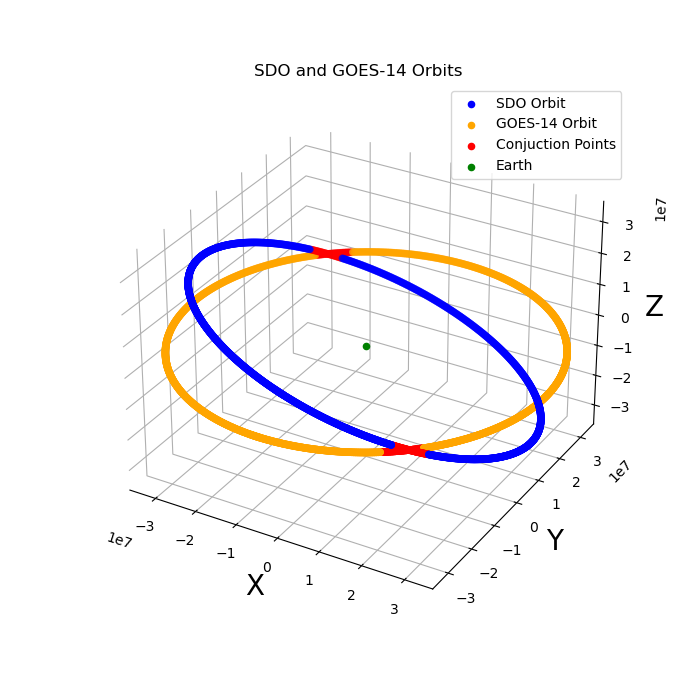

In [8]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
im1 = ax.scatter3D(x_sdo_no_eq,y_sdo_no_eq,z_sdo_no_eq, s=20, label = 'SDO Orbit',c='blue') #ax.plot3D(x, y, z, 'gray')
im2 = ax.scatter3D(x_goes_no_eq,y_goes_no_eq,z_goes_no_eq, s=20, label = 'GOES-14 Orbit',c='orange')
im3 = ax.scatter3D(x_sdo_eq,y_sdo_eq,z_sdo_eq, s=20, label = 'Conjuction Points',c='red') #ax.plot3D(x, y, z, 'gray')
im4 = ax.scatter3D(x_goes_eq,y_goes_eq,z_goes_eq, s=20,c='red')
ax.scatter3D(0, 0, 0, c='green',label='Earth')
ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
ax.set_zlabel('Z',fontsize=20)
ax.axes.set_xlim3d(left=-35000*1000, right=35000*1000)
ax.axes.set_ylim3d(bottom=-35000*1000, top=35000*1000) 
ax.axes.set_zlim3d(bottom=-35000*1000, top=35000*1000) 
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_title('SDO and GOES-14 Orbits')
plt.legend()
#fig.colorbar(im,fraction=0.035, pad=0.1)

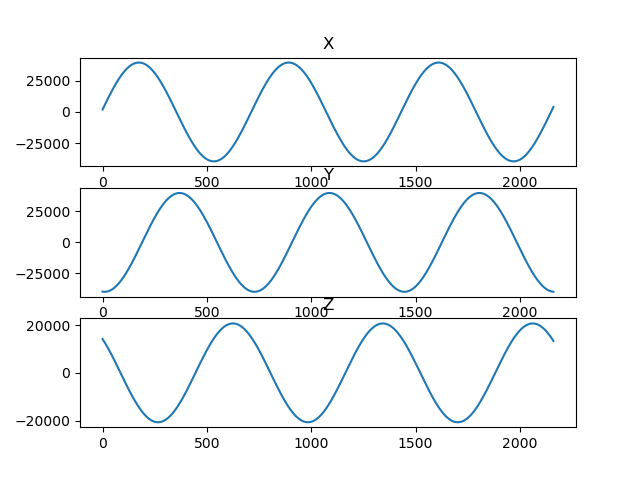

In [9]:
figure, axis = plt.subplots(3, 1)
axis[0].plot(x_sdo); axis[0].set_title("X")
axis[1].plot(y_sdo); axis[1].set_title("Y")
axis[2].plot(z_sdo); axis[2].set_title("Z")
plt.show()

In [10]:
print(np.sqrt(x_sdo[0]**2 + y_sdo[0]**2 + z_sdo[0]**2))

42160.302129203395


# Calculate Minimum Distance Between SDO and GOES-14

In [12]:
distance = np.sqrt((x_sdo-x_goes)**2+(y_sdo-y_goes)**2+(z_sdo-z_goes)**2)

In [20]:
print('Minimum Distance: ',np.min(distance), 'km')

Minimum Distance:  1642.051265102944 km


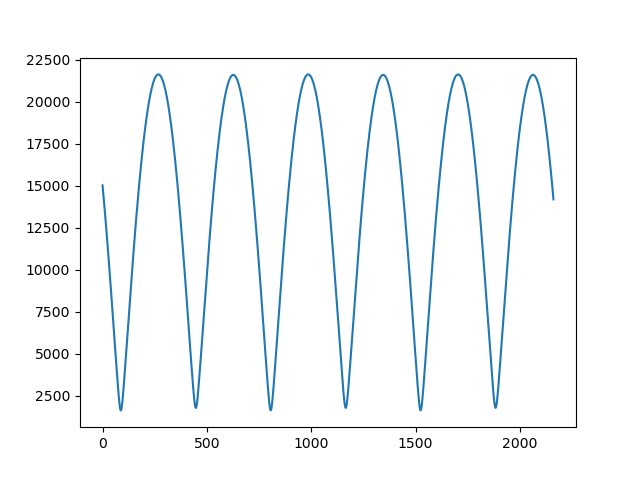

In [15]:
plt.figure()
plt.plot(distance)
plt.show()

# Read and Treat Data

In [ ]:
# SDO
df_sdo = dd.read_parquet("/efs/sdoradbelt/data/sdo_headers", columns=['NSPIKES','WAVELNTH','GAEZ_OBS','GAEX_OBS','GAEY_OBS','QUALITY','EXPTIME'])
df_sdo = df_sdo.set_index(df_sdo.index, sorted=True) # solve the sorting issue

In [ ]:
# GOES (Select Telescope, Electron Flux and Parameter)
telescope = 2 #choose any from 1-9
e_flux_kV = [40,75,150,275,475]; e_flux_idx = 1 # choose from 1 to 5
df_goes = dd.read_parquet("/efs/sdoradbelt/data/goes_data/maged/goes_telescope{}_keV{}.parquet".format(telescope,e_flux_kV[e_flux_idx-1]))

# Geocentric Solar Ecliptic (GSE) coordinates

In [ ]:
nc = netCDF4.Dataset('/efs/sdoradbelt/data/raw_data/dn_goes-l2-orb1m_g14_y2018_v0_0.nc', mode='r')
goes_coords = np.array(nc.variables['gse_xyz'][:])
x_goes = goes_coords[:,0]*1000 #[0:2000]*1000
y_goes = goes_coords[:,1]*1000 #[0:2000]*1000
z_goes = goes_coords[:,2]*1000 #[0:2000]*1000

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
day_mins = 60*24
im2 = ax.scatter3D(x_goes[0:day_mins],y_goes[0:day_mins],z_goes[0:day_mins], s=0.25, label = 'GOES-14')
im2 = ax.scatter3D(x_goes[0+30*day_mins:day_mins+30*day_mins],y_goes[0+30*day_mins:day_mins+30*day_mins],z_goes[0+30*day_mins:day_mins+30*day_mins], s=0.25, label = 'GOES-14')
im2 = ax.scatter3D(x_goes[0+2*30*day_mins:day_mins+2*30*day_mins],y_goes[0+2*30*day_mins:day_mins+2*30*day_mins],z_goes[0+2*30*day_mins:day_mins+2*30*day_mins], s=0.25, label = 'GOES-14')
im2 = ax.scatter3D(x_goes[0+3*30*day_mins:day_mins+3*30*day_mins],y_goes[0+3*30*day_mins:day_mins+3*30*day_mins],z_goes[0+3*30*day_mins:day_mins+3*30*day_mins], s=0.25, label = 'GOES-14')
im2 = ax.scatter3D(x_goes[0+4*30*day_mins:day_mins+4*30*day_mins],y_goes[0+4*30*day_mins:day_mins+4*30*day_mins],z_goes[0+4*30*day_mins:day_mins+4*30*day_mins], s=0.25, label = 'GOES-14')
im2 = ax.scatter3D(x_goes[0+5*30*day_mins:day_mins+5*30*day_mins],y_goes[0+5*30*day_mins:day_mins+5*30*day_mins],z_goes[0+5*30*day_mins:day_mins+5*30*day_mins], s=0.25, label = 'GOES-14')
im2 = ax.scatter3D(x_goes[0+6*30*day_mins:day_mins+6*30*day_mins],y_goes[0+6*30*day_mins:day_mins+6*30*day_mins],z_goes[0+6*30*day_mins:day_mins+6*30*day_mins], s=0.25, label = 'GOES-14')
#im2 = ax.scatter3D(x_goes[0+7*30*day_mins:day_mins+7*30*day_mins],y_goes[0+7*30*day_mins:day_mins+7*30*day_mins],z_goes[0+7*30*day_mins:day_mins+7*30*day_mins], s=0.25, label = 'GOES-14')
#im2 = ax.scatter3D(x_goes[0+8*30*day_mins:day_mins+8*30*day_mins],y_goes[0+8*30*day_mins:day_mins+8*30*day_mins],z_goes[0+8*30*day_mins:day_mins+8*30*day_mins], s=0.25, label = 'GOES-14')
#im2 = ax.scatter3D(x_goes[0+9*30*day_mins:day_mins+9*30*day_mins],y_goes[0+9*30*day_mins:day_mins+9*30*day_mins],z_goes[0+9*30*day_mins:day_mins+9*30*day_mins], s=0.25, label = 'GOES-14')
#im2 = ax.scatter3D(x_goes[0+10*30*day_mins:day_mins+10*30*day_mins],y_goes[0+10*30*day_mins:day_mins+10*30*day_mins],z_goes[0+10*30*day_mins:day_mins+10*30*day_mins], s=0.25, label = 'GOES-14')
#im2 = ax.scatter3D(x_goes[0+11*30*day_mins:day_mins+11*30*day_mins],y_goes[0+11*30*day_mins:day_mins+11*30*day_mins],z_goes[0+11*30*day_mins:day_mins+11*30*day_mins], s=0.25, label = 'GOES-14')
#im2 = ax.scatter3D(x_goes[0+12*30*day_mins:day_mins+12*30*day_mins],y_goes[0+12*30*day_mins:day_mins+12*30*day_mins],z_goes[0+12*30*day_mins:day_mins+12*30*day_mins], s=0.25, label = 'GOES-14')
ax.scatter3D(0, 0, 0, cmap='blue')
ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
ax.set_zlabel('Z',fontsize=20)
plt.legend()

In [ ]:
plt.plot(x_goes[0:day_mins],z_goes[0:day_mins])
plt.plot(x_goes[0+30*day_mins:day_mins+30*day_mins],z_goes[0+30*day_mins:day_mins+30*day_mins])
plt.plot(x_goes[0+2*30*day_mins:day_mins+2*30*day_mins],z_goes[0+2*30*day_mins:day_mins+2*30*day_mins])
plt.plot(x_goes[0+3*30*day_mins:day_mins+3*30*day_mins],z_goes[0+3*30*day_mins:day_mins+3*30*day_mins])
plt.plot(x_goes[0+4*30*day_mins:day_mins+4*30*day_mins],z_goes[0+4*30*day_mins:day_mins+4*30*day_mins])
plt.plot(x_goes[0+5*30*day_mins:day_mins+5*30*day_mins],z_goes[0+5*30*day_mins:day_mins+5*30*day_mins])
plt.plot(x_goes[0+6*30*day_mins:day_mins+6*30*day_mins],z_goes[0+6*30*day_mins:day_mins+6*30*day_mins])
plt.show()

In [ ]:
nc.variables

# Geographic coordinate system (GEO)

In [ ]:
nc2 = netCDF4.Dataset('/efs/sdoradbelt/data/raw_data/dn_goes-l2-orb1m_g14_y2018_v0_0.nc', mode='r')
goes_GEO_coords = np.array(nc2.variables['geo_llr'][:])
goes_time = np.array(nc2.variables['time'][:])

In [ ]:
nc2.variables

In [ ]:
print(np.shape(goes_GEO_coords))

In [ ]:
plt.plot(goes_time)

In [ ]:
JD = 2458119.5

In [ ]:
T = JD - 2451545.0 / 36525

In [ ]:
GMST = 24110.54841 + 8640184.812866 * T + 0.093104 * T**2 - 0.0000062 * T**3

In [ ]:
conversion_matrix = np.array([[np.cos(GMST), -np.sin(GMST), 0], [np.sin(GMST), np.cos(GMST), 0],[0, 0, 1]])

In [ ]:
np.shape(conversion_matrix)

In [ ]:
np.shape(goes_GEO_coords)

In [ ]:
goes_GEI_coords = np.matmul(conversion_matrix, np.transpose(goes_GEO_coords))

In [ ]:
np.shape(goes_GEI_coords)

In [ ]:
x_goes_GEI = goes_GEI_coords[0,:][0:1*24*60]#*1000
y_goes_GEI = goes_GEI_coords[1,:][0:1*24*60]#*1000
z_goes_GEI = goes_GEI_coords[2,:][0:1*24*60]#*1000

In [ ]:
plt.plot(z_goes_GEI)

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
day_mins = 60*24
im2 = ax.scatter3D(x_goes_GEI,y_goes_GEI,z_goes_GEI, s=0.25, label = 'GOES-14')
#ax.scatter3D(0, 0, 0, cmap='blue')
ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
ax.set_zlabel('Z',fontsize=20)
plt.legend()

In [ ]:
plt.plot(x_goes_GEI,z_goes_GEI)